## Run MCMC inference using GP model

In [41]:
import random
import time

import tikzplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS


import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE.priors import SquaredExponential
from experiments.zimbabwe_utility import read_data

numpyro.set_host_device_count(4)

import yaml
import flax.linen as nn
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params

import os
from os import listdir

from scipy.stats import gaussian_kde

import arviz as az
import matplotlib

In [42]:
data_path = "../../zimbabwe/data/zwe2016phia.geojson"

#num_warmup = 5000
#num_samples = 50000

#num_warmup = 1000
#num_samples = 10000

#num_warmup = 100
#num_samples = 400
#num_chains = 3

kernel_gp = SquaredExponential()

## Load Data

In [43]:
os.getcwd()

'/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/notebooks/zimbabwe'

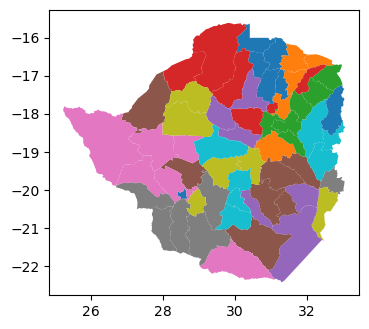

/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe_utility.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


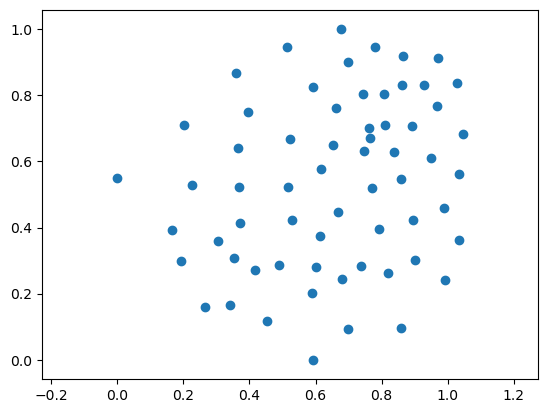

In [44]:
data = gpd.read_file(data_path)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data.plot(column='area_id', ax=ax, legend=False)

plt.show()

x, data_centroid = read_data(data_path, normalize=True)

plt.scatter(x[:, 1], x[:, 0])
plt.axis("equal")

## Adding estimate data
data_centroid["estimate"] = data["estimate"]

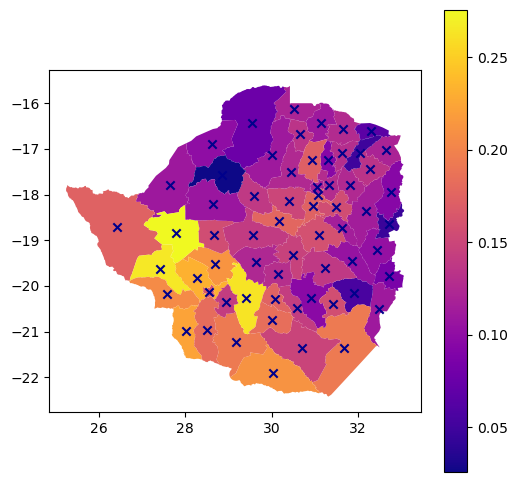

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
data_centroid.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
data_centroid["centroid"].plot(ax=ax, color="DarkBlue", marker="x")
plt.show()

## Observations

In [46]:
data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

## GP Prior

In [47]:
def model_gp(x, n_obs=None, kernel=kernel_gp, lengthscale=None, y=None):
    
    if lengthscale == None:
        lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2.5, 10.0)) 
        
    kernel.lengthscale = lengthscale
    k = kernel(x, x)
    
    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(re))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

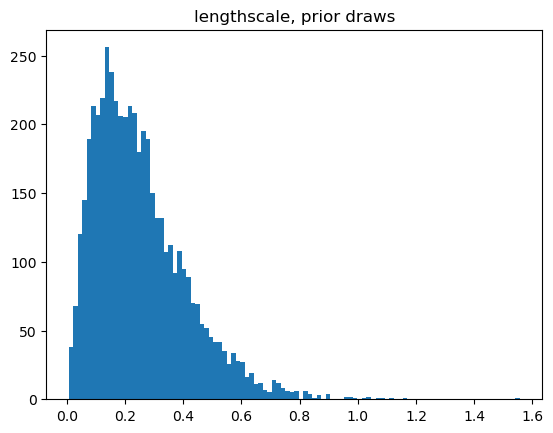

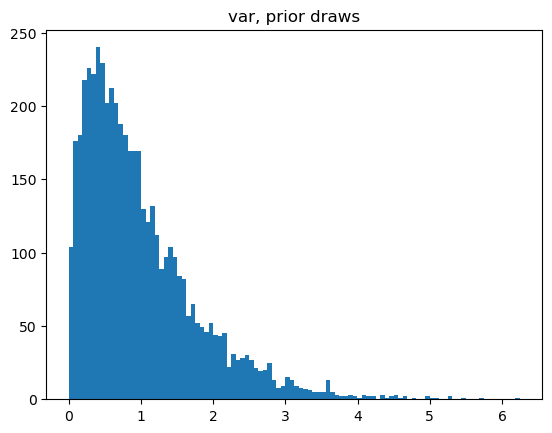

In [48]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_gp, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['lengthscale']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['variance']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

## MCMC Inference using GP Prior - load models from cluster

A few models were exe

In [52]:
os.getcwd()

'/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/notebooks/zimbabwe'

In [53]:
#mcmc_fits_path = "../../mcmc_fits"

In [54]:
mcmc_fits_path = "/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/mcmc_fits"
mcmc_fits_files = listdir(mcmc_fits_path)

model_number = 0
model_path = mcmc_fits_path +'/'+ mcmc_fits_files[model_number]
mcmc1 = az.from_netcdf(model_path)

OSError: Unable to open file (file signature not found)

In [19]:
rng_key = jax.random.PRNGKey(42)

start = time.time()
mcmc_gp_model = NUTS(model_gp)
mcmc_gp = MCMC(mcmc_gp_model, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_gp.run(rng_key, x=x, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y), kernel=SquaredExponential())
t_elapsed = time.time() - start

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

In [20]:
mcmc_gp.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.35      0.03      0.35      0.29      0.40      3.10      2.52
    re_std[0]     -1.20      0.09     -1.25     -1.30     -1.06      1.73      3.20
    re_std[1]     -1.37      0.10     -1.35     -1.51     -1.24      1.54      9.11
    re_std[2]     -1.39      0.10     -1.37     -1.52     -1.27      1.55      9.61
    re_std[3]     -1.67      0.16     -1.75     -1.82     -1.39      1.60      5.35
    re_std[4]     -1.81      0.14     -1.82     -2.02     -1.56      2.16      1.93
    re_std[5]     -1.61      0.13     -1.61     -1.81     -1.39      1.98      2.13
    re_std[6]     -1.67      0.14     -1.65     -1.89     -1.49      1.57      5.76
    re_std[7]     -1.79      0.14     -1.86     -1.94     -1.55      1.69      3.27
    re_std[8]     -1.84      0.17     -1.82     -2.11     -1.60      2.00      2.37
    re_std[9]     -1.85      0.23     -1.78     -2.25     -1.58      1.86  

In [22]:
# print("\nMCMC elapsed time:", round(t_elapsed), "s")

# ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
# r = jnp.mean(ss['re']['n_eff'])
# print("Average ESS for all REs : " + str(round(r)))

### Converting to arviz InfereceData

In [23]:
inference_data = az.from_numpyro(mcmc_gp)

In [24]:
np.testing.assert_allclose(data["y"], inference_data.observed_data.obs)

### Saving InferenceData object into netCDF format

In [25]:
inference_data.to_netcdf('mcmc_fits/zimbabwe_norm_rbf.nc')

'mcmc_fits/zimbabwe_norm_rbf.nc'

## Plotting

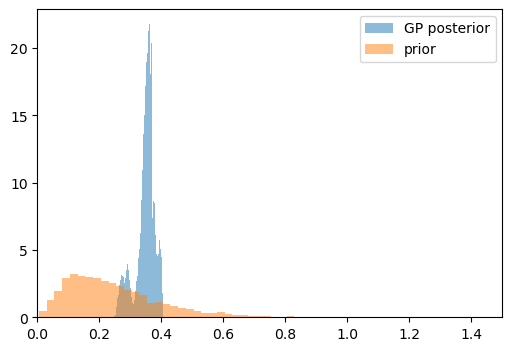

In [26]:
c_samps_gp = inference_data.posterior.lengthscale.values.reshape((-1, ))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_gp, density=True, label = 'GP posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
plt.xlim([0, 1.5])

#tikzplotlib.save(r"lengthscale.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

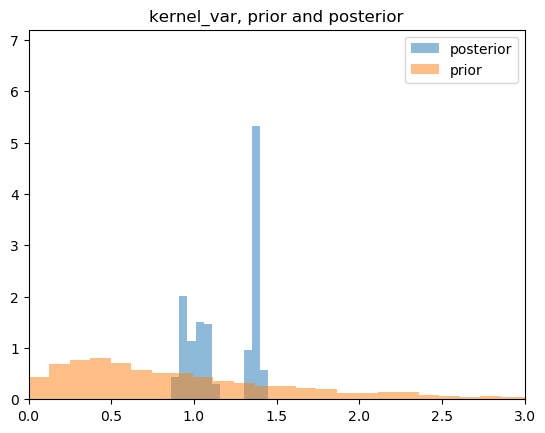

In [18]:
var_samps_gp = inference_data.posterior.variance.values.reshape((-1, ))
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

# tikzplotlib.save(r"variance.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

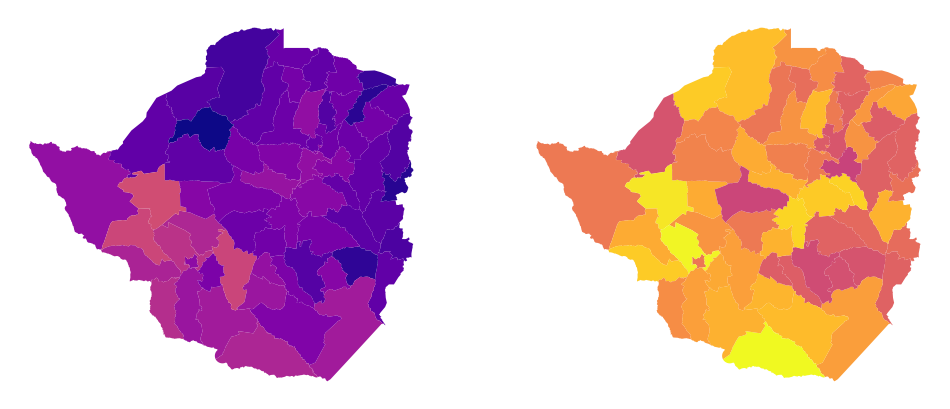

In [46]:
theta_samps_gp = inference_data.posterior.theta.values
theta_samps_gp = theta_samps_gp.reshape((-1, theta_samps_gp.shape[-1]))
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = jnp.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = jnp.quantile(theta_samps_gp, 0.75, axis=0)

data['theta_gp'] = theta_mean_gp

theta_observed = jnp.array(data['estimate'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
data.plot(column="estimate", ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")

In [16]:
#fname = 'mcmc_fits/tmp_gp.pkl'

#with open(fname, 'wb') as file:
#    pickle.dump(mcmc_gp, file)

In [10]:
# inference_data = az.from_numpyro(mcmc_gp)
# inference_data.to_netcdf('mcmc_fits/test.nc')
# inference_data_loaded = az.from_netcdf('mcmc_fits/test.nc')

In [13]:
#fname = 'mcmc_fits/zimbabwe_gp_mcmc_RBF_normalised_Gamma_{}iter.pkl'.format(num_samples)

#with open(fname, 'wb') as f:
#    dill.dump(mcmc_gp, f)

#with open(path + 'mcmc1.pkl', 'rb') as f:
#    mcmc1 = dill.load(f)

In [14]:
#fname = 'mcmc_fits/tmp.pkl'

#with open(fname, 'wb') as f:
#    dill.dump(mcmc_gp, f)

#with open(fname, 'rb') as f:
#    mcmc1 = dill.load(f)

In [15]:
#fname = 'mcmc_fits/zimbabwe_gp_mcmc_RBF_normalised_Gamma_{}iter.pkl'.format(num_samples)

# Save trained MCMC model
#with open(fname, 'wb') as file:
#    pickle.dump(mcmc_gp, file)

In [17]:
#mcmc_gp.print_summary(exclude_deterministic=True)
#mcmc_gp_samples = mcmc_gp.get_samples()

In [81]:
# print("\nMCMC elapsed time:", round(t_elapsed), "s")

# ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
# r = jnp.mean(ss['re']['n_eff'])
# print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 213 s
Average ESS for all REs : 2


In [17]:
# c_samps_gp = mcmc_gp_samples['lengthscale']

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# plt.hist(c_samps_gp, density=True, label = 'GP posterior', bins=50, alpha=0.5)
# plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# # plt.title('lengthscale, prior and posterior')
# plt.legend()
# plt.xlim([0, 1.5])

# #tikzplotlib.save(r"lengthscale.tex",
# #                 figurewidth='\\figurewidth', figureheight='\\figureheight',
# #                 figure=fig)

# plt.show()

In [18]:
# var_samps_gp = mcmc_gp_samples['variance']
# plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
# plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('kernel_var, prior and posterior')
# plt.legend()
# plt.xlim(0,3)

# # tikzplotlib.save(r"variance.tex",
# #                 figurewidth='\\figurewidth', figureheight='\\figureheight',
# #                 figure=fig)

# plt.show()

In [19]:
# # posterior predictive
# posterior_predictive_gp = Predictive(model_gp, mcmc_gp_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
#                                                                          x=x, 
#                                                                          n_obs = jnp.array(data.n_obs))


# theta_samps_gp = posterior_predictive_gp['theta']
# theta_mean_gp = theta_samps_gp.mean(axis=0)
# bci_gp_25 = jnp.quantile(theta_samps_gp, 0.25, axis=0)
# bci_gp_75 = jnp.quantile(theta_samps_gp, 0.75, axis=0)

# data['theta_gp'] = theta_mean_gp

# theta_observed = jnp.array(data['estimate'])
# theta_estimated_gp = jnp.array(data['theta_gp'])

# _max = np.max([theta_observed, theta_estimated_gp])
# _min = np.min([theta_observed, theta_estimated_gp])

# fig, ax = plt.subplots(1, 2, figsize=(12,6))
# data.plot(column="estimate", ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

# ax[0].axis("off")
# ax[1].axis("off")

In [22]:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

#plt.axis("off")
#plt.tight_layout()
#plt.savefig("estimate.pdf")
#plt.show()

In [23]:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#data.plot(column="theta_gp", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

#plt.axis("off")
#plt.tight_layout()
#plt.savefig("gp_inference.pdf")
#plt.show()

## Define model - PriorCVAE

In [48]:
#outputs_path = "../../outputs/"
#outputs_path = "../../outputs/outputs_90jobs"
outputs_path = "../../outputs/outputs_rbf_normalized"

from os import listdir

print(listdir(outputs_path))

print(len(listdir(outputs_path)))

['2024-02-07', 'efynxet1', 'vdqtcltt', 'lad3r4vv', '02g2lize', '6h5h7tzw', '2024-02-06', '7yi0j5wg', 'h7n950lp', 'teg57g7c', 'usm3gmln', 'luq5pyjh', '2mfieep0', 'qerrqzvc', 'n7djdwpv', '0jx5y3iw', 'i1ayn414', 'ykth1iax', 'bfjv1o6o', 'iferpucb', '878nuaz6', '6abkw9fm', '5r3pr1d1', '2kqd3c1w', 'zdb1spgj', 'evsqvv14', 'plfbtoh5', 'wjfj0cw7', '8rivtsgl', '5sv12yb1', 'x32jyqx0', 'ud0zna7j', '45qydp3s', 'a67ri9kk', 't8v53i5n', 'idcc4bpi', 'ihfceefj', 'pc4cgvrc', 'yhbbpxjw', '2w6t5ih9', 'z3u9eb8a', 'haaf4dm6', 'pyvev513', 'y1w9nusg']
44


In [49]:
#data_path = "../../zimbabwe/data/zwe2016phia.geojson"

dirs = listdir(outputs_path) 
#dirs = ["6dv9hm9r", "c9olhh5v", "fvk8l9r1", "vmp2r78b", "yzgfmgh6"]


dir_paths = ["../../outputs/outputs_rbf_normalized/" + dirs[i] for i in range(len(dirs))]
dir_paths = [item for item in dir_paths if '.DS_Store' not in item]
dir_paths = [item for item in dir_paths if '2024-' not in item]

#dir_paths = ["../../outputs/" + dirs[i] for i in range(len(dirs))]
#dir_paths = ["../../outputs/outputs_90jobs/" + dirs[i] for i in range(len(dirs))]
#dir_paths = [item for item in dir_paths if '.DS_Store' not in item]

#dir_paths = ["../../outputs/an8xbohc"]
dir_paths

['../../outputs/outputs_rbf_normalized/efynxet1',
 '../../outputs/outputs_rbf_normalized/vdqtcltt',
 '../../outputs/outputs_rbf_normalized/lad3r4vv',
 '../../outputs/outputs_rbf_normalized/02g2lize',
 '../../outputs/outputs_rbf_normalized/6h5h7tzw',
 '../../outputs/outputs_rbf_normalized/7yi0j5wg',
 '../../outputs/outputs_rbf_normalized/h7n950lp',
 '../../outputs/outputs_rbf_normalized/teg57g7c',
 '../../outputs/outputs_rbf_normalized/usm3gmln',
 '../../outputs/outputs_rbf_normalized/luq5pyjh',
 '../../outputs/outputs_rbf_normalized/2mfieep0',
 '../../outputs/outputs_rbf_normalized/qerrqzvc',
 '../../outputs/outputs_rbf_normalized/n7djdwpv',
 '../../outputs/outputs_rbf_normalized/0jx5y3iw',
 '../../outputs/outputs_rbf_normalized/i1ayn414',
 '../../outputs/outputs_rbf_normalized/ykth1iax',
 '../../outputs/outputs_rbf_normalized/bfjv1o6o',
 '../../outputs/outputs_rbf_normalized/iferpucb',
 '../../outputs/outputs_rbf_normalized/878nuaz6',
 '../../outputs/outputs_rbf_normalized/6abkw9fm',


In [50]:
#output_dir = "../../outputs/6dv9hm9r"
#data_path = "../../zimbabwe/data/zwe2016phia.geojson"
#n_samples = 5000

In [51]:
def model_cvae(trained_decoder_params, latent_dim, n_obs=None, lengthscale=None, y=None):
    
    lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2.5, 10.0)) 

    c = jnp.array([lengthscale])

    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    z = jnp.concatenate([z, c]) 
    f = numpyro.deterministic('f', decoder.apply({'params': trained_decoder_params}, z))
     
    re = numpyro.deterministic('re', kernel_var * f)
    
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(re))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

In [52]:
c_samps_cvae_lst = []

#for i in range(len(dir_paths)):
for i in range(1):
    print(i)
    output_dir = dir_paths[i]
    print(output_dir)
    cfg_path = os.path.join(output_dir, "files", "config.yaml")
    with open(cfg_path, 'r') as file:
        cfg_data = yaml.safe_load(file)

    conditional = cfg_data["conditional"]['value']
    latent_dim = cfg_data["latent_dim"]['value']
    normalize = cfg_data["normalize"]['value']
    dec_activation_fn = cfg_data["dec_activation"]['value']["_target_"]
    dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

    trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
    output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
    hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
    decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

    rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

    # inference
    start = time.time()
    kernel = NUTS(model_cvae)
    mcmc_cvae = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_cvae.run(rng_key, trained_decoder_params, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
    t_elapsed = time.time() - start
    print(t_elapsed)

    mcmc_cvae.print_summary(exclude_deterministic=True)

    mcmc_cvae_samples = mcmc_cvae.get_samples()

    c_samps_cvae = mcmc_cvae_samples['lengthscale']

    c_samps_cvae_lst.append(c_samps_cvae)

0
../../outputs/outputs_rbf_normalized/efynxet1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

6.056674242019653

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.34      0.05      0.34      0.26      0.41    174.74      1.01
     variance      1.64      0.46      1.56      0.96      2.35    326.08      1.00
         z[0]      0.07      1.03      0.03     -1.58      1.86   1886.27      1.00
         z[1]      0.07      0.97      0.06     -1.54      1.64   1989.20      1.00
         z[2]     -0.06      1.02     -0.08     -1.93      1.36   2627.59      1.00
         z[3]      0.13      1.05      0.12     -1.51      1.86   1666.11      1.00
         z[4]     -0.23      1.02     -0.20     -2.02      1.35   1951.63      1.00
         z[5]      0.15      0.95      0.16     -1.35      1.82   1510.32      1.00
         z[6]     -0.55      0.85     -0.58     -2.02      0.74    768.13      1.00
         z[7]      0.03      1.00      0.06     -1.60      1.70   1541.60      1.00
         z[8]      0.22      0.99      0.17     -1.41    

## Save PriorCVAE-MCMC

In [26]:
#i = 12
#output_dir = dir_paths[i]
#print(output_dir)
#cfg_path = os.path.join(output_dir, "files", "config.yaml")
#with open(cfg_path, 'r') as file:
#    cfg_data = yaml.safe_load(file)

#cfg_data.keys()

#conditional = cfg_data["conditional"]['value']
#latent_dim = cfg_data["latent_dim"]['value']
#normalize = cfg_data["normalize"]['value']
#dec_activation_fn = cfg_data["dec_activation"]['value']["_target_"]
#dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

IndexError: list index out of range

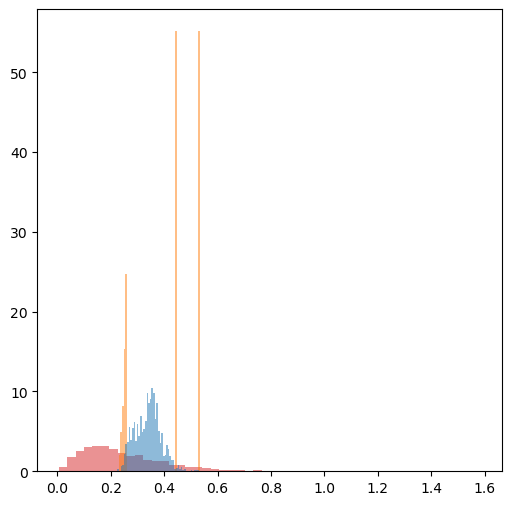

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

plt.hist(ls_prior_draws, density=True, bins=50, alpha=0.5, color="tab:red", label='prior')
plt.hist(c_samps_gp, density=True, bins=50, alpha=0.5, color="tab:orange", label='GP')

#for i in range(len(c_samps_cvae_lst)):
for i in range(15):
    plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])

plt.legend()
plt.xlim(0, 1.)
plt.show()

IndexError: list index out of range

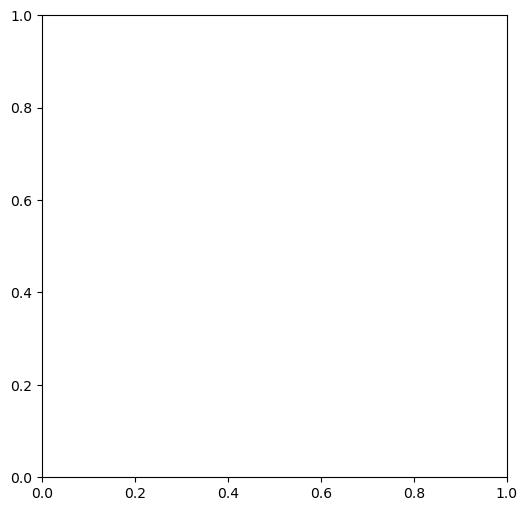

In [56]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
for i in range(15, 30):
    plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])

plt.legend()
plt.xlim(0, 1.)
plt.show()

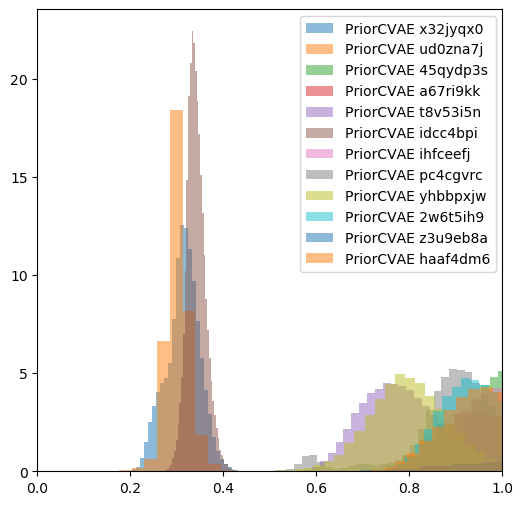

In [19]:

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
for i in range(30, len(c_samps_cvae_lst)):
    #plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, color="tab:blue", label='PriorCVAE')
    plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])

plt.legend()
plt.xlim(0, 1.)
plt.show()

In [20]:
def make_kde(data):
    density = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 200)
    y_vals = density(x_vals)

    return x_vals, y_vals

['#101C4B', '#7A7C3A', '#CBB598', '#0B3FDE', '#B4D177', '#782326', '#F270AB', '#34AF87', '#B792FC', '#17F43C', '#8A18AD', '#A4A55E', '#8CF58A', '#740705', '#1D5CD0', '#179955', '#AF4168', '#59F8B6', '#4C920B', '#6928A6', '#16BD30', '#075E6A', '#3DD9AF', '#A5FB2C', '#CA2DFC', '#AFDD7B', '#8769BD', '#CF1DA3', '#0CFAF3', '#61F34C', '#211357', '#9FCA6D', '#842BAB', '#4BF453', '#64E6FF', '#DAB6BC', '#053220', '#25E781', '#9C1FE1', '#C72636', '#D44E41', '#F570EC']


(0, 1.0)

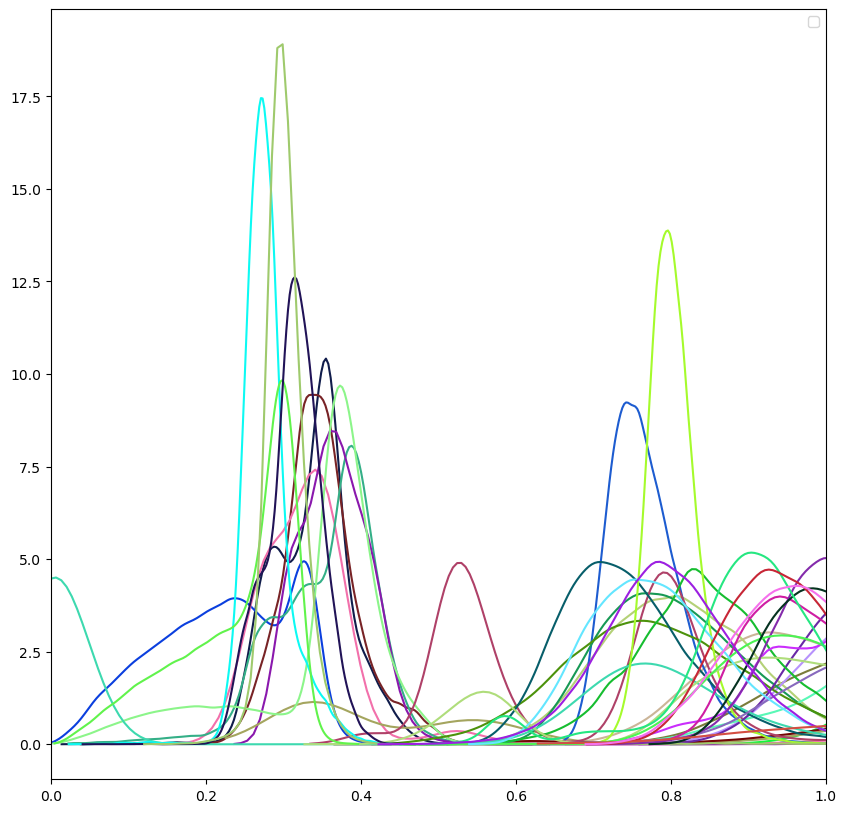

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

number_of_colors = len(c_samps_cvae_lst)

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
print(colors)

for i in range(len(c_samps_cvae_lst)):
    x_vals, y_vals = make_kde(c_samps_cvae_lst[i])
    if np.sum(y_vals > 20) == 0:
        #plt.plot(x_vals, y_vals, 'r', label='PriorCVAE ' + dirs[i], color=colors[i])
        plt.plot(x_vals, y_vals, 'r', color=colors[i])

plt.legend()
plt.xlim(0, 1.)

In [82]:
#fig, axs = plt.subplots(1, 1, figsize=(8, 8))

#x_vals, y_vals = make_kde(ls_prior_draws)
#plt.plot(x_vals, y_vals, 'r', label='prior', color="tab:red")
#plt.fill_between(x_vals, 0, y_vals, color="tab:red", alpha=0.3)

#x_vals, y_vals = make_kde(c_samps_gp)
#plt.plot(x_vals, y_vals, 'r', label='GP posterior', color="tab:orange")
#plt.fill_between(x_vals, 0, y_vals, color="tab:orange", alpha=0.3)

#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
#colors = list(np.random.choice(range(256), size=len(c_samps_cvae_lst)))

#for i in range(len(c_samps_cvae_lst)):
#    x_vals, y_vals = make_kde(c_samps_cvae_lst[i])
#    #plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])
#    plt.plot(x_vals, y_vals, 'r', label='PriorCVAE ' + dirs[i], color=colors[i])

#plt.legend()
#plt.xlim(0, 1.)